In [1]:
# import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
plt.style.use('fivethirtyeight')

In [3]:
#read the user engagement data
engagement = pd.read_csv('relax_challenge/takehome_user_engagement.csv')
engagement.head()

,time_stamp,user_id,visited
0,2014-04-22 03:53:30,1,1
1,2013-11-15 03:45:04,2,1
2,2013-11-29 03:45:04,2,1
3,2013-12-09 03:45:04,2,1
4,2013-12-25 03:45:04,2,1


In [4]:
#check how many users and how many logins
print('There were {} users and {} total logins'.format(
    engagement['user_id'].nunique(), len(engagement)
))

There were 8823 users and 207917 total logins


In [5]:
# convert time_stamp into datetime format
engagement['time_stamp'] = pd.to_datetime(
    engagement['time_stamp'], format='%Y-%m-%d %H:%M:%S'
)

In [6]:
# define a function to see if a user logged in on 3 seperate days in a 7-day period.
def logins_in_days(df, days=7, logins=3):
    from datetime import timedelta
    # first drop duplicate days and sort by day
    df['date'] = df['time_stamp'].dt.date
    df = df.drop_duplicates(subset='date').sort_values('date')
    # calculate how many days has passed for every 3 logins
    passed_days = df['date'].diff(periods=logins-1)
    # check if any passed time is less than 7 days
    return any(passed_days <= timedelta(days=days))

In [7]:
# run the function on all users
adopted = engagement.groupby('user_id').apply(logins_in_days)
adopted.name = 'adopted_user'

In [8]:
print('There were {} adopted users out of {} users'.format(
    sum(adopted), len(adopted)))

There were 1656 adopted users out of 8823 users


In [13]:
# read the user data
# some columns such as name, email address are not useful here
# let's not read them
cols = ['object_id', 'creation_source', 'creation_time', 
        'last_session_creation_time', 'opted_in_to_mailing_list',
        'enabled_for_marketing_drip', 'org_id', 'invited_by_user_id']
#users = pd.read_csv('relax_challenge/takehome_users.csv', usecols=cols)
users = pd.read_csv('relax_challenge/takehome_users.csv', encoding = "ISO-8859-1")
users.head()

,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1.398139e+09,1,0,11,10803.0
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1.396238e+09,0,0,1,316.0
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,1.363735e+09,0,0,94,1525.0
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,1.369210e+09,0,0,1,5151.0
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,1.358850e+09,0,0,193,5240.0


There were likely too many organizations and user invites to model. Let's do a quick survey of the organizations with most users and users who sent out most invites. Then drop those two features.

In [14]:
# 5 Organizations with most users
users['org_id'].value_counts().head()

0    319
1    233
2    201
3    168
4    159
Name: org_id, dtype: int64

In [15]:
# 5 Users with most invites
users['invited_by_user_id'].value_counts().head()

10741.0    13
2527.0     12
1525.0     11
11770.0    11
2308.0     11
Name: invited_by_user_id, dtype: int64

In [16]:
# remove those two features
users = users.drop(['org_id', 'invited_by_user_id'], axis=1)

From the creation time and last session time, we can engineer two features that can be useful.
It is possible that the history of using the software might be a factor of becoming "adopted users". In other words, users who have used the software for a long time might be more likely to be "adopted users" than those who had just signed up.
It is likely that user adoption rate vary through time, so it is useful to take a look at account age (based on creation time) as well.

In [17]:
# create a feature of user history
# convert both time features into datetime
users['creation_time'] = pd.to_datetime(
    users['creation_time'], format='%Y-%m-%d %H:%M:%S')
users['last_session_creation_time'] = pd.to_datetime(
    users['last_session_creation_time'], unit='s')
# calculate user history, defined as number of days between account creation and last use
users['history'] = users['last_session_creation_time'] - users['creation_time']
users['history'] = users['history'].dt.days
# calculate account age, defined as number of days since account creation and now
# I don't know when this dataset was collected. Let's use the latest date in creation_time
latest = max(users['creation_time'])
users['account_age'] = latest - users['creation_time']
users['account_age'] = users['account_age'].dt.days
# drop the two original columns
users = users.drop(['creation_time', 'last_session_creation_time'], axis=1)

In [18]:
users.head()

,object_id,name,email,creation_source,opted_in_to_mailing_list,enabled_for_marketing_drip,history,account_age
0,1,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1,0,0.0,38
1,2,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,0,0,136.0,196
2,3,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,0,0,0.0,437
3,4,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,0,0,1.0,374
4,5,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,0,0,5.0,498


In [19]:
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12000 entries, 0 to 11999
Data columns (total 8 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   object_id                   12000 non-null  int64  
 1   name                        12000 non-null  object 
 2   email                       12000 non-null  object 
 3   creation_source             12000 non-null  object 
 4   opted_in_to_mailing_list    12000 non-null  int64  
 5   enabled_for_marketing_drip  12000 non-null  int64  
 6   history                     8823 non-null   float64
 7   account_age                 12000 non-null  int64  
dtypes: float64(1), int64(4), object(3)
memory usage: 750.1+ KB


There were 8823 users who had "user history" out of 12000. It was not clear from the challenge description whether data for other users were missing, or don't exist at all. However, given there are users who has history of 0 days, I think the engagement data for the other users were simply missing. Therefore, I will remove these users from the analysis.

In [20]:
# merge user data and "adopted user" variable
users = users.set_index('object_id')
users.index.name = 'user_id'
data = pd.concat([users, adopted], axis=1, join='inner')
data['adopted_user'] = data['adopted_user'].astype(int)

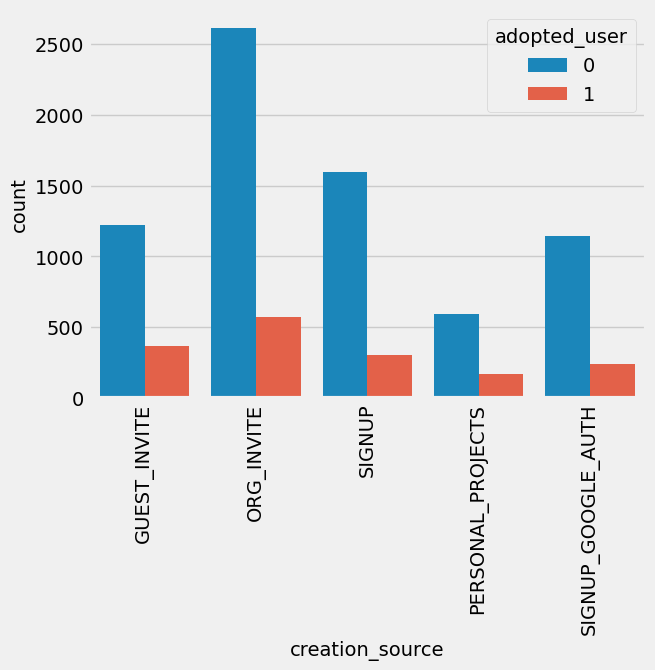

In [21]:
# Creation source and adopted user
_ = sns.countplot(x='creation_source', data=data, hue='adopted_user')
_ = plt.xticks(rotation=90)

In [22]:
# doesn't look like there was much difference among creation sources
# let's do a chi2 test
from scipy.stats import chi2_contingency
crosstab = pd.crosstab(data['creation_source'], data['adopted_user'])
results = chi2_contingency(crosstab)
print('chi2 = {}\tp = {}'.format(results[0], results[1]))

chi2 = 41.27933208242451	p = 2.3526508745340972e-08


In [23]:
# hmm, chi2 test significant, but how much was the difference
data.groupby('creation_source')['adopted_user'].apply(lambda x: sum(x)/len(x))

creation_source
GUEST_INVITE          0.232368
ORG_INVITE            0.180050
PERSONAL_PROJECTS     0.225131
SIGNUP                0.159115
SIGNUP_GOOGLE_AUTH    0.172563
Name: adopted_user, dtype: float64

OK, slightly higher "adopted user" rate in guest_invite and personal_projects, that makes sense because users who got invite probably was collaborting with others, and users who have personal projects are likely to have more personal interest that make them more engaged.

In [24]:
# check mailing list and marketing drip
data.groupby('opted_in_to_mailing_list')['adopted_user'].apply(lambda x: sum(x)/len(x))

opted_in_to_mailing_list
0    0.185994
1    0.192722
Name: adopted_user, dtype: float64

In [25]:
def z_test(df, col, target='adopted_user'):
    from statsmodels.stats.weightstats import CompareMeans
    opted_in = df.loc[data[col]==1, target]
    opted_out = df.loc[data[col]==0, target]
    z_data = CompareMeans.from_data(opted_in, opted_out)
    z, p = CompareMeans.ztest_ind(z_data)
    print('For {}, z = {}, p = {}'.format(col, z, p))
z_test(data, 'opted_in_to_mailing_list')

For opted_in_to_mailing_list, z = 0.7029779128148219, p = 0.4820695142048773


In [26]:
data.groupby('enabled_for_marketing_drip')['adopted_user'].apply(lambda x: sum(x)/len(x))

enabled_for_marketing_drip
0    0.186982
1    0.191648
Name: adopted_user, dtype: float64

There was really no difference between users who signed up or not for mailing list and marketing drip.

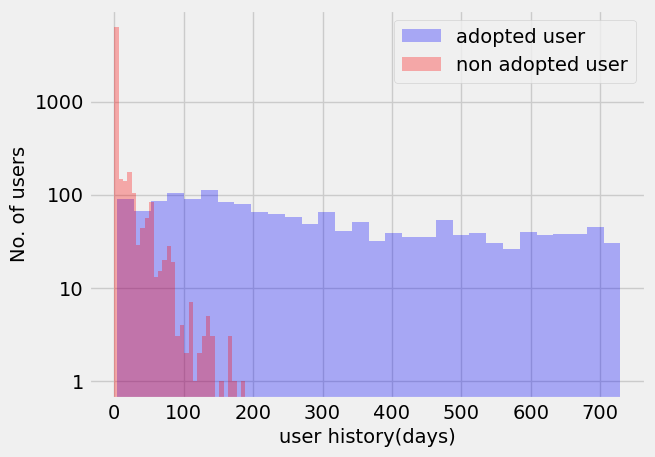

In [27]:
# history and adopted user
def plot_hist_days(df, col, xlabel):
    _ = plt.hist(df.loc[data['adopted_user']==1, col], 
                 bins=30, alpha=0.3, color='b', label='adopted user')
    _ = plt.hist(df.loc[data['adopted_user']==0, col], 
                 bins=30, alpha=0.3, color='r', label='non adopted user')
    _ = plt.yscale('log')
    _ = plt.legend()
    _ = plt.xlabel(xlabel)
    _ = plt.ylabel('No. of users')
    _ = plt.yticks([1, 10, 100, 1000], ['1', '10', '100', '1000'])
plot_hist_days(data, 'history', 'user history(days)')

Pretty clear that users with long history are more likely to be adopted users.

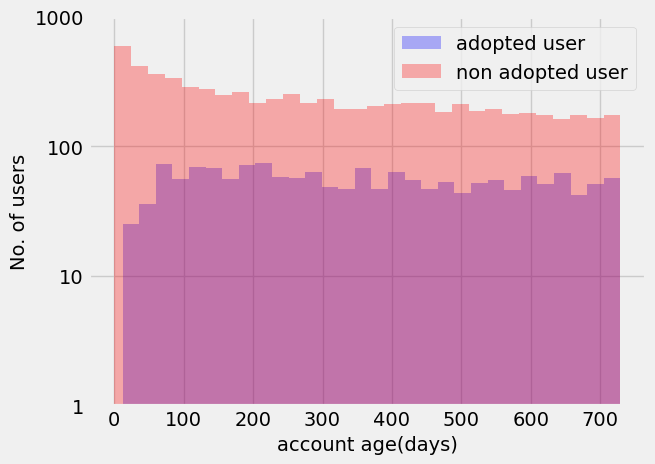

In [28]:
plot_hist_days(data, 'account_age', 'account age(days)')

Not surprisingly, the adoption rate is lower in very new accounts. Other than that, the adoption rate didn't change much over the past two years.